# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead.

In [1]:
import pandas as pd
from core.preprocessing import make_small_train, make_small_dev
from core.neural_net_forecaster import NeuralNetForecaster

df = pd.read_pickle('data/master_dataset.pkl').fillna(0)

dftrain = make_small_train(df, 'combined')
dfdev = make_small_dev(df)

problem = NeuralNetForecaster(dftrain, dfdev)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Training

In [2]:
problem.make_forecasts()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               432100    
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 36)                2916      
Total params: 443,096
Trainable params: 443,096
Non-trainable params: 0
_________________________________________________________________
None
Iteration 0
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 311us/step - loss: 2692.0752 - mean_squared_error: 2686.0209 - val_loss: 1134.8491 - val_mean_squared_error: 1129.2398
Iteration 1
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 310us/step - loss: 1119.8696 - mean_square

Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 227us/step - loss: 358.3332 - mean_squared_error: 344.4380 - val_loss: 341.0074 - val_mean_squared_error: 327.0655
Iteration 33
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 227us/step - loss: 359.9280 - mean_squared_error: 345.9698 - val_loss: 417.2893 - val_mean_squared_error: 403.3443
Iteration 34
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 226us/step - loss: 375.2955 - mean_squared_error: 361.4120 - val_loss: 349.7635 - val_mean_squared_error: 335.8961
Iteration 35
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 226us/step - loss: 340.1580 - mean_squared_error: 326.3946 - val_loss: 289.4394 - val_mean_squared_error: 275.7371
Iteration 36
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [

7776/7776 [==============================] - 2s 228us/step - loss: 307.1132 - mean_squared_error: 295.0052 - val_loss: 282.6477 - val_mean_squared_error: 270.5682
Iteration 68
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 227us/step - loss: 313.1606 - mean_squared_error: 301.0607 - val_loss: 325.1356 - val_mean_squared_error: 313.1016
Iteration 69
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 228us/step - loss: 308.0059 - mean_squared_error: 295.9422 - val_loss: 322.9920 - val_mean_squared_error: 310.9699
Iteration 70
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 224us/step - loss: 309.5067 - mean_squared_error: 297.4746 - val_loss: 286.6844 - val_mean_squared_error: 274.6569
Iteration 71
Train on 7776 samples, validate on 864 samples
Epoch 1/1
7776/7776 [==============================] - 2s 224us/step - loss: 3

## Prediction

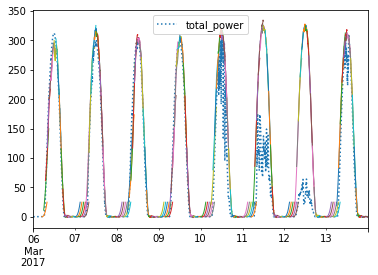

In [3]:
import matplotlib.pyplot as plt
problem.plot_test()
plt.show()

In [4]:
problem.calc_mse()

6482.298255148874